In [1]:
%matplotlib inline

import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm
from typing import List, Optional
import glob

from facemesh import FaceMeshBlock, FaceMesh
from pupil_detection import IrisLM, IrisBlock
from util_funcs import pad_image
from face_detector import FaceDetector

filterwarnings('ignore')
tqdm.pandas()

### Dataset

In [2]:
class EyesExtractor:
    def __init__(
        self,
        save_folder: Optional[str] = None,
        facemesh_weights: str = "./weights/facemesh.pth",
        device: str = "cpu"
    ):
        self.facemesh =  FaceMesh().to(device)
        self.facemesh.load_weights(facemesh_weights)
        self.left_eye_indices = [33, 7, 163, 144, 145, 153, 154, 155,
                                 246, 161, 160, 159, 158, 157, 173, 133]
        self.right_eye_indices = [249, 263, 362, 373, 374, 380, 381, 382,
                                  384, 385, 386, 387, 388, 390, 398, 466]

    def get_eye_crop(self, points: np.array, img: np.array, which_eye: str):
        h, w, _ = img.shape
        sorted_point_x = sorted(points, key = lambda x: x[0])
        sorted_point_y = sorted(points, key = lambda x: x[1])
        left_point = sorted_point_x[0]
        right_point = sorted_point_x[-1]
        up_point = sorted_point_y[0]
        down_point = sorted_point_y[-1]
        multiplicator = 1/2
        margin_x_left = max(64 - (right_point[0] - left_point[0]), 0) * multiplicator
        margin_x_right = max(64 - (right_point[0] - left_point[0]), 0) * (1 - multiplicator)
        margin_y = max(64 - (down_point[1] - up_point[1]), 0) / 2
        min_x, max_x = max(0, int(left_point[0] - margin_x_left)), min(w, int(right_point[0] + margin_x_right))
        min_y, max_y = max(0, int(up_point[1] - margin_y)), min(h, int(down_point[1] + margin_y))
        img_eye = img[min_y: max_y, min_x: max_x, :]
        left_top_point = (min_x, min_y) 
        return img_eye, left_top_point


    def extract_eyes(self, face_crop: np.ndarray):
        face_crop = cv2.resize(face_crop, (192, 192), interpolation = cv2.INTER_LINEAR)
        face_crop = cv2.flip(face_crop, 1)
        facemesh_points = self.facemesh.predict_on_image(face_crop).cpu().numpy()
        left_eye_points = facemesh_points[self.left_eye_indices]
        right_eye_points = facemesh_points[self.right_eye_indices]
        img_eye_left, _ = self.get_eye_crop(left_eye_points, face_crop, which_eye = "left")
        img_eye_right, _ = self.get_eye_crop(right_eye_points, face_crop, which_eye = "right")
        return img_eye_left, img_eye_right

In [3]:
class GazeDetectionDataset(Dataset):
    """Gaze detection dataset."""

    def __init__(
        self,
        data: pd.DataFrame,
        transform_list: Optional[List]= None,
        to_tensors: bool = False,
        device: str = "cpu",
        inference: bool = False
    ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data.copy()
        self.to_tensors = to_tensors
        transform_list_ = transform_list.copy()
        if to_tensors:
            transform_list_.append(ToTensorV2())
        transform_list_eyes = []
        if to_tensors:
            transform_list_eyes.append(ToTensorV2())
        self.transform = A.Compose(transform_list_)
        self.transform_eyes = A.Compose(transform_list_eyes)
        transform_list_mask = [A.Resize(25, 25)]
        if to_tensors:
            transform_list_mask.append(ToTensorV2())
        self.transform_mask = A.Compose(transform_list_mask)
        self.device = torch.device(device)
        self.faceCascade = cv2.CascadeClassifier("./weights/haarcascade_frontalface_alt.xml")
        self.eyesExtractor = EyesExtractor(device = device)
        self.inference = inference
        if device != "cpu":
            device = str(0)
        self.face_detector = FaceDetector(device = device)


    def get_face_mask(self, frame, face_rect):
        mask = np.zeros((frame.shape[0], frame.shape[1]))
        if face_rect is None:
            return mask
        mask[
            face_rect[1] : face_rect[1] + face_rect[3],
            face_rect[0] : face_rect[0] + face_rect[2]
        ] = 1
        return mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        img_path = row['paths']
        try:
            image_orig = cv2.imread(img_path)
            image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
            image, face_rect = self.face_detector.detect_face(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            face_mask = self.get_face_mask(image_orig, face_rect)
            image_eye_l, image_eye_r = self.eyesExtractor.extract_eyes(image)
            image = image / 255.
            image_eye_l = image_eye_l / 255.
            image_eye_r = image_eye_r / 255.
        except Exception:
            raise Exception(f"Image {img_path}, {eye_left_path} failed loading")
        if not self.inference:
            coordinates = row[['x_normalized', 'y_normalized']].values.astype(np.float32)
        
        if self.transform:
            image = self.transform(image = image)['image']
            face_mask = self.transform_mask(image = face_mask)['image']
            image_eye_l = self.transform_eyes(image = image_eye_l)['image']
            image_eye_r = self.transform_eyes(image = image_eye_r)['image']
            if self.to_tensors:
                if not self.inference:
                    coordinates = torch.from_numpy(coordinates).to(self.device)
                image = image.type(torch.float32).to(self.device)
                image_eye_l = image_eye_l.type(torch.float32).to(self.device)
                image_eye_r = image_eye_r.type(torch.float32).to(self.device)
                face_mask = face_mask.type(torch.float32).to(self.device)
            
        sample = {'image': image, "eye_l": image_eye_l,
                  "eye_r": image_eye_r, "face_mask": face_mask}
        if not self.inference:
            sample['coordinates'] = coordinates
        return sample

#### Extract frames

In [4]:
from pathlib import Path
from video2images import Video2Images

In [5]:
out_folder = "./test_frames_2"

In [73]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [74]:
Video2Images(video_filepath="./test_2.mov",
             save_format=".png",
             out_dir=out_folder)

 Video Duration is 0hr: 0min: 36sec 
 The input Video FPS is 30 frames/sec
 Capture rate is default FPS of input video i.e 30 frames/sec


 Capturing Frames... : 1093iter [04:03,  4.48iter/s]                            

 Done. Total frames captured: 1093 


In [75]:
!ls $out_folder

'frames_folder_2023-09-28 10:10:46'


In [76]:
tmp_dir =  f"{out_folder}/frames_folder_2023-09-28 10:10:46/"

In [77]:
filenames = os.listdir(tmp_dir)

In [78]:
for filename in filenames:
    os.rename(os.path.join(tmp_dir, filename), os.path.join(out_folder, filename))

In [79]:
!rm -r "./test_frames_2/frames_folder_2023-09-28 10:10:46/"

In [6]:
p = Path(out_folder).glob('*.png')

In [7]:
paths = [str(path.absolute()) for path in p]

In [8]:
df_files = pd.DataFrame({"paths": paths})
df_files["ind"] = df_files.paths.apply(lambda x: int(Path(x).stem))
df_files = df_files.sort_values("ind").set_index("ind")

In [9]:
df_files.head(3)

,paths
ind,
1,/home/ubuntu/projects/tweakle/gaze_detection/t...
2,/home/ubuntu/projects/tweakle/gaze_detection/t...
3,/home/ubuntu/projects/tweakle/gaze_detection/t...


In [10]:
df = pd.read_csv("./data_tobii_names.csv")

In [11]:
df = df[(df["x_normalized"] < 1.2) & (df["y_normalized"] < 1.1)]

In [12]:
trans_list = [
        A.Resize(192, 192),
        # ToTensorV2()
    ]

In [86]:
# data = pd.read_csv("./tobii_train_sub_updv2.csv")

Fusing layers... 
0 (192, 192, 3)


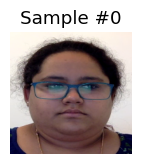

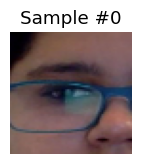

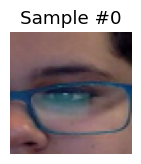

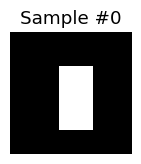

1 (192, 192, 3)


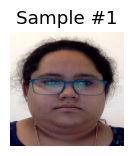

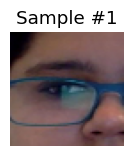

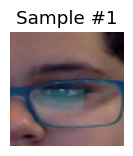

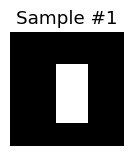

2 (192, 192, 3)


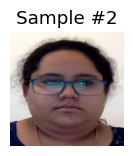

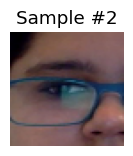

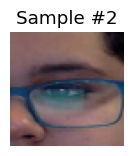

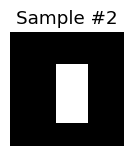

3 (192, 192, 3)


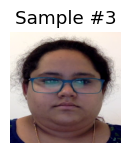

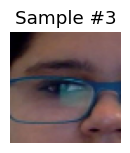

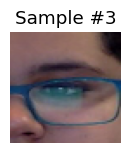

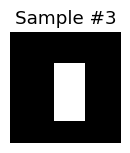

In [12]:
face_dataset = GazeDetectionDataset(data=df.tail(200), transform_list=trans_list, inference=True)

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(np.array(sample['image']))
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_l'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_r'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['face_mask'], cmap = "gray")
    plt.show()
    if i == 3:
        plt.show()
        break

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [15]:
face_dataset = GazeDetectionDataset(data = df, transform_list=trans_list, to_tensors=True, device=device, inference=True)

Fusing layers... 


In [16]:
for i, sample in enumerate(face_dataset):
    print(i, sample['image'].size(), sample['eye_l'].size(), sample['face_mask'].size())
    if i == 3:
        break

0 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
1 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
2 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
3 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])


### Model

In [14]:
pretrained_model_face = FaceMesh()
pretrained_model_face.load_weights("./weights/facemesh.pth")

model_path = "./weights/irislandmarks.pth"
pretrained_model_eyes = IrisLM()
weights = torch.load(model_path)
pretrained_model_eyes.load_state_dict(weights)

<All keys matched successfully>

In [15]:
class FaceGridModel(nn.Module):
    def __init__(self, gridSize = 25):
        super(FaceGridModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(gridSize * gridSize, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [16]:
class EyesModel(nn.Module):
    def __init__(self, pretrained_model_eyes: nn.Module):
        super(EyesModel, self).__init__()
        self.backbone = pretrained_model_eyes.backbone
        self.regression_head_eyes = nn.Sequential(
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
        )
        # connect eyes
        self.fc = nn.Sequential(
            nn.Linear(2 * 128 * 1 * 1, 128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_eye_l, x_eye_r):
        x_eye_l = self.backbone(x_eye_l)
        x_eye_l = self.regression_head_eyes(x_eye_l)
        x_eye_l = x_eye_l.view(-1, 128 * 1 * 1)

        x_eye_r = self.backbone(x_eye_r)
        x_eye_r = self.regression_head_eyes(x_eye_r)
        x_eye_r = x_eye_r.view(-1, 128 * 1 * 1)
        x = torch.cat([x_eye_l, x_eye_r], 1)
        x = self.fc(x)
        return x

In [17]:
class FaceModel(nn.Module):
    def __init__(self, pretrained_model_face: nn.Module):
        super(FaceModel, self).__init__()
        self.backbone = pretrained_model_face.backbone
        self.regression_head_face = nn.Sequential(
            FaceMeshBlock(128, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
            nn.Conv2d(128, 32, 1),
            nn.PReLU(32),
            FaceMeshBlock(32, 32),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
        )

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0

    def forward(self, x_face):
        x_face = self._preprocess(x_face)
        x_face = nn.ReflectionPad2d((1, 0, 1, 0))(x_face)
        x_face = self.backbone(x_face)
        x_face = self.regression_head_face(x_face)
        x_face = x_face.view(-1, 32 * 3 * 3)
        x = self.fc(x_face)
        return x

In [18]:
class FineTuneModel(nn.Module):
    def __init__(self, pretrained_model_face: nn.Module, pretrained_model_eyes: nn.Module):
        super(FineTuneModel, self).__init__()
        self.face_model = FaceModel(pretrained_model_face)
        self.eyes_model = EyesModel(pretrained_model_eyes)
        self.face_grid_model = FaceGridModel()
        self.fc = nn.Sequential(
            nn.Linear(128+64+128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0
        
    def forward(self, x_face, x_eye_l, x_eye_r, x_grid):
        x_eyes = self.eyes_model(x_eye_l, x_eye_r)
        x_face = self.face_model(x_face)
        x_grid = self.face_grid_model(x_grid)
        x = torch.cat([x_eyes, x_face, x_grid], axis = 1)
        x = self.fc(x)
        return x

In [19]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes).to(device)

In [20]:
rand_img = np.random.randint(0, 255, (2, 3, 192,192))
x_face = torch.from_numpy(rand_img).to(device)
rand_img = (np.random.randint(0, 255, (2, 3, 64, 64)) / 255.)
x_eye = torch.from_numpy(rand_img).type(torch.float32).to(device)
rand_grid = (np.random.randint(0, 255, (2, 25, 25)) / 255.)
x_grid = torch.from_numpy(rand_grid).type(torch.float32).to(device)

In [21]:
model(x_face, x_eye, x_eye, x_grid)

tensor([[-0.29479,  0.06285],
        [-0.20782,  0.05201]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
CHECKPOINTS_PATH = "./checkpoints"
EXPERIMENT_NAME = "face_eyes_mask_less_data_correctedv2_tune"

In [23]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes).to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt")))
model.eval()

FineTuneModel(
  (face_model): FaceModel(
    (backbone): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): PReLU(num_parameters=16)
      (2): FaceMeshBlock(
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
          (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (act): PReLU(num_parameters=16)
      )
      (3): FaceMeshBlock(
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
          (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (act): PReLU(num_parameters=16)
      )
      (4): FaceMeshBlock(
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16)
          (1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
   

In [25]:
def inference(model: FineTuneModel, dataloader_eval: DataLoader):
    model.eval()
    preds_list = []
    for i, data in tqdm(enumerate(dataloader_eval), total = len(dataloader_test)):
        inputs, inputs_eye_l, inputs_eye_r, inputs_mask = data['image'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask']
        with torch.no_grad():
            outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask)
        preds_list += outputs.cpu().detach().tolist()
        if i % 10 == 0:
            preds = np.vstack(preds_list)
            df_copy = df.copy().head(len(preds))
            df_copy["pred_x"] = preds.T[0]
            df_copy["pred_y"] = preds.T[1]
            df_copy.to_csv("./tobii_full_pred_3.csv", index = False)
            print(f"Result saved on {i} batch with {df_copy.shape[0]}/{df.shape[0]}  samples processed")
    return preds_list

In [26]:
# torch.cuda.empty_cache()

In [27]:
dataset_test = GazeDetectionDataset(data = df.iloc[493560 + 2048: ], transform_list=trans_list, to_tensors=True, device=device, inference=True)
dataloader_test = DataLoader(dataset_test, batch_size=2048,
                        shuffle=False)

Fusing layers... 


In [28]:
preds = inference(model, dataloader_test)

  1%|▎                                        | 1/115 [01:03<2:01:32, 63.97s/it]

Result saved on 0 batch with 2048/730320  samples processed


 10%|███▊                                    | 11/115 [13:37<2:19:59, 80.76s/it]

Result saved on 10 batch with 22528/730320  samples processed


 18%|███████▎                                | 21/115 [28:09<2:14:40, 85.96s/it]

Result saved on 20 batch with 43008/730320  samples processed


 27%|██████████▊                             | 31/115 [40:16<1:43:15, 73.75s/it]

Result saved on 30 batch with 63488/730320  samples processed


 36%|██████████████▎                         | 41/115 [52:44<1:37:35, 79.13s/it]

Result saved on 40 batch with 83968/730320  samples processed


 44%|████████████████▊                     | 51/115 [1:04:18<1:14:06, 69.48s/it]

Result saved on 50 batch with 104448/730320  samples processed


 53%|████████████████████▏                 | 61/115 [1:16:16<1:05:41, 72.98s/it]

Result saved on 60 batch with 124928/730320  samples processed


 62%|████████████████████████▋               | 71/115 [1:27:45<50:43, 69.17s/it]

Result saved on 70 batch with 145408/730320  samples processed


 70%|████████████████████████████▏           | 81/115 [1:40:30<43:15, 76.34s/it]

Result saved on 80 batch with 165888/730320  samples processed


 79%|███████████████████████████████▋        | 91/115 [1:52:48<29:28, 73.69s/it]

Result saved on 90 batch with 186368/730320  samples processed


 88%|██████████████████████████████████▎    | 101/115 [2:04:31<16:32, 70.92s/it]

Result saved on 100 batch with 206848/730320  samples processed


 97%|█████████████████████████████████████▋ | 111/115 [2:16:15<04:50, 72.75s/it]

Result saved on 110 batch with 227328/730320  samples processed


100%|███████████████████████████████████████| 115/115 [2:20:52<00:00, 73.50s/it]


In [31]:
df_1 = pd.read_csv("./tobii_full_pred.csv")
df_2 = pd.read_csv("./tobii_full_pred_2.csv")
df_3 = pd.read_csv("./tobii_full_pred_3.csv")

In [35]:
preds = np.vstack(preds)

In [38]:
df_copy = df.iloc[493560 + 2048: ].copy()

In [39]:
df_copy["pred_x"] = preds.T[0]
df_copy["pred_y"] = preds.T[1]

In [ ]:
# condition = ((df_copy["x_normalized"] > 0.6) & (df_copy["pred_x"] < 0.4)) | \
#             ((df_copy["x_normalized"] < 0.4) & (df_copy["pred_x"] > 0.6))
# df_copy = df_copy[~condition]

In [42]:
df_full  = pd.concat([df_1, df_2, df_3, df_copy]).drop_duplicates(subset = ["paths"])
df_full.shape

(728280, 6)

In [43]:
df_full.to_csv("./tobii_full_pred_final.csv", index = False)

In [107]:
x, y = np.array(preds).T

In [104]:
x = 1 - x

In [108]:
width_screen_cm, height_screen_cm = 304, 212

In [ ]:
# width_screen_px, height_screen_px = 304, 212

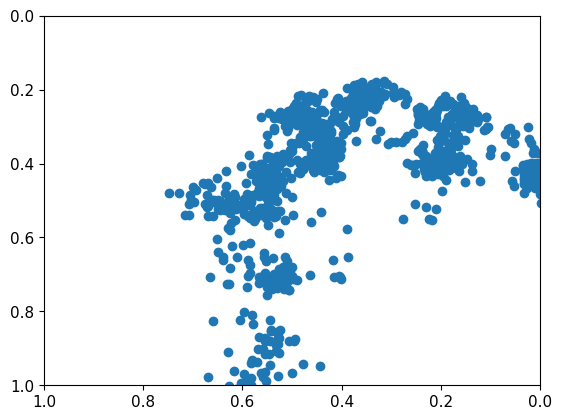

In [118]:
# plt.imshow(np.zeros((height_screen_cm, width_screen_cm)), cmap = "gray")
plt.scatter(x, y)
plt.ylim(1, 0)
plt.xlim(1, 0)
plt.show()

In [127]:
res_folder = "./test_results"

In [128]:
!rm -r $res_folder

In [129]:
!mkdir $res_folder

In [130]:
for i in tqdm(range(len(x))):
    fig = plt.figure()
    fig.patch.set_visible(False)
    plt.scatter([x[i]], [y[i]])
    plt.ylim(1, 0)
    plt.xlim(1, 0)
    plt.savefig(f"{res_folder}/{i}.png")
    plt.close(fig)

100%|███████████████████████████████████████| 1093/1093 [01:55<00:00,  9.45it/s]


In [131]:
filenames = sorted(glob.glob(f"{res_folder}/*.png"), key = lambda x: int(Path(x).stem))

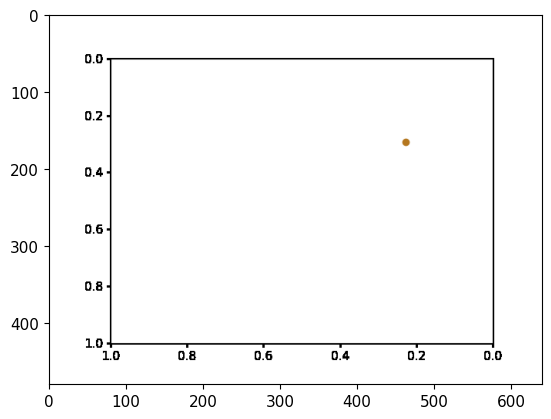

In [132]:
img = cv2.imread(filenames[100])
plt.imshow(img)

In [133]:
h, w, _ = img.shape

In [134]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
fps = 30
video = cv2.VideoWriter('gaze_2.mp4', fourcc, fps, (w, h))
for filename in tqdm(filenames):
    img = cv2.imread(filename)
    video.write(img)

cv2.destroyAllWindows()
video.release()

100%|██████████████████████████████████████| 1093/1093 [00:06<00:00, 166.97it/s]
